In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

# Generate an artificial gamma-ray spectrum (sum of Gaussians)
def gaussian(x, mu, sigma, amplitude):
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Define energy channels
x = np.linspace(0, 10, 500)  # Energy range from 0 to 10 MeV

true_spectrum = np.zeros_like(x)
true_spectrum[100:110] = 100
true_spectrum[200:210] = 80
true_spectrum[300:310] = 120

# Construct response matrix R (simulating detector effects)
n = len(x)
R = np.zeros((n, n))
for i in range(n):
    R[:, i] = gaussian(x, x[i], 0.3, 1)  # Each column is a Gaussian spread

# Compute observed spectrum (detected counts)
observed_spectrum = R @ true_spectrum

# Perform Singular Value Decomposition
U, S, Vt = svd(R)

# Compute the Moore-Penrose inverse
S_inv = np.zeros((n, n))
for i in range(n):
    if S[i] > 1e-6:  # Avoid division by very small singular values
        S_inv[i, i] = 1 / S[i]

R_inv = Vt.T @ S_inv @ U.T  # Compute pseudoinverse
deconvoluted_spectrum = R_inv @ observed_spectrum  # Solve for x



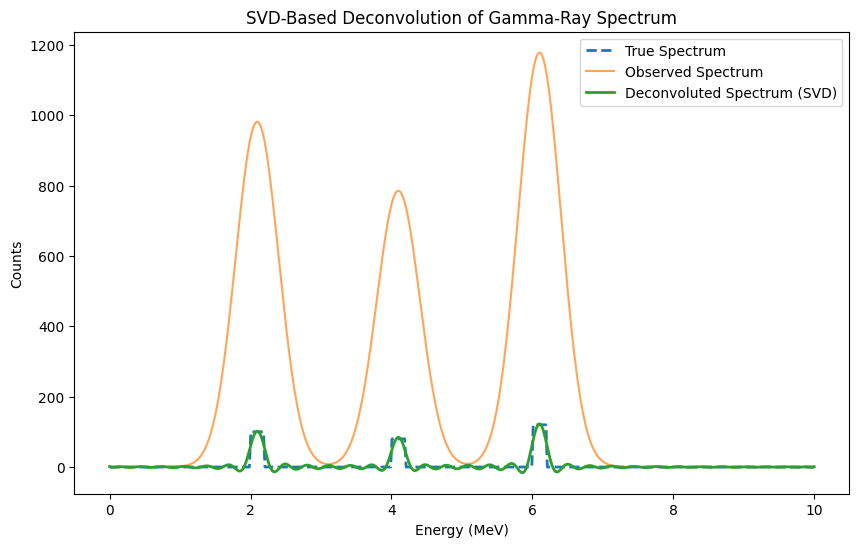

In [4]:
# Plot results
plt.figure(figsize=(10, 6))

plt.plot(x, true_spectrum, label="True Spectrum", linestyle="dashed", linewidth=2)
plt.plot(x, observed_spectrum, label="Observed Spectrum", alpha=0.7)
# np.diag(S)
# plt.plot(x, np.diag(S_inv), label="Deconvoluted Spectrum (SVD)", linewidth=2)
plt.plot(x, deconvoluted_spectrum, label="Deconvoluted Spectrum (SVD)", linewidth=2)

plt.xlabel("Energy (MeV)")
plt.ylabel("Counts")
plt.legend()
plt.title("SVD-Based Deconvolution of Gamma-Ray Spectrum")
plt.show()


In [5]:
import numpy as np
from scipy.optimize import minimize

def phi(x, y, alpha):
    """
    Compute the objective function Φ(x) for gamma spectrum deconvolution.
    
    Parameters:
    x (numpy array): The solution vector (must be non-negative).
    R (numpy array): The response matrix.
    y (numpy array): The observed spectrum.
    alpha (float): Regularization parameter.
    
    Returns:
    float: Value of the function Φ(x).
    """
    R = np.zeros((n, n))
    for i in range(n):
        R[:, i] = gaussian(x, x[i], 0.3, 1)  # Each column is a Gaussian spread

    # Compute observed spectrum (detected counts)
    observed_spectrum = R @ true_spectrum

    residual = observed_spectrum - y  # Compute R*x - y
    term1 = 0.5 * np.linalg.norm(residual) ** 2  # First term: 1/2 ||Rx - y||^2
    term2 = 0.5 * alpha * np.linalg.norm(x) ** 2  # Second term: α/2 ||x||^2
    
    return term1 + term2

def optimize_x(y, alpha):
    """
    Minimize the function Φ(x) subject to x >= 0.
    
    Parameters:
    R (numpy array): The response matrix.
    y (numpy array): The observed spectrum.
    alpha (float): Regularization parameter.
    
    Returns:
    numpy array: Optimized x vector.
    """
    n = y.shape[-1]  # Dimension of x
    x0 = np.zeros(n)  # Initial guess (non-negative)
    
    # Constraints: x >= 0
    bounds = [(0, None)] * n  # No upper bound, only non-negative constraint
    
    # Optimize using L-BFGS-B
    result = minimize(phi, x0, args=(y, alpha), method='L-BFGS-B', bounds=bounds)
    
    if result.success:
        return result.x
    else:
        raise RuntimeError("Optimization failed:", result.message)

In [6]:
optimal_x = optimize_x(observed_spectrum, alpha=1e-3)

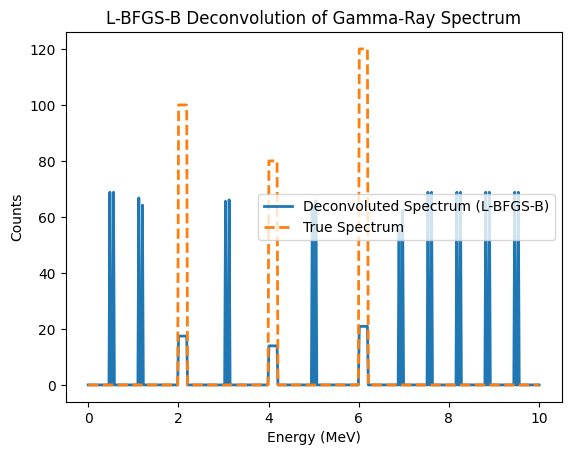

In [7]:

plt.plot(x, optimal_x, label="Deconvoluted Spectrum (L-BFGS-B)", linewidth=2)
plt.plot(x, true_spectrum, label="True Spectrum", linestyle="dashed", linewidth=2)
plt.xlabel("Energy (MeV)")
plt.ylabel("Counts")
plt.title("L-BFGS-B Deconvolution of Gamma-Ray Spectrum")
plt.legend()
plt.show()